In [1]:
# Standard library
import re
import string

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from spellchecker import SpellChecker
import emoji

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.model_selection import GridSearchCV

nltk.download('wordnet')
nltk.download('omw-1.4')  # for improved lemmatization support


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# ============================================================
# Preprocessing pipeline for TF-IDF + LR
# ============================================================

chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocessing_pipeline(review: str):
    """
    Clean and preprocess a review string using the full pipeline.

    Args:
        review (str): The raw review text.
    Returns:
        str: The cleaned and preprocessed review text.
    """
    # 1. quick lowercase (won’t hurt)
    review = review.lower()

    # 2. strip HTML
    review = BeautifulSoup(review, "html.parser").get_text()

    # 3. strip URLs
    review = re.sub(r'http\S+|www\.\S+', '', review, flags=re.IGNORECASE)

    # 4. strip [bracketed] parts
    review = re.sub(r'\[[^]]*\]', '', review)

    # 5. remove emoji
    review = emoji.replace_emoji(review, replace='')

    # 6. strip punctuation
    review = review.translate(str.maketrans('', '', string.punctuation))

    # 7. chat-word expansion  (done **before** stop-word removal)
    new_text = []
    for word in review.split():
        if word.upper() in chat_words:
            new_text.append(chat_words[word.upper()])
        else:
            new_text.append(word)
    review = " ".join(new_text)

    # 8. lowercase again so expansions are uniform
    review = review.lower()

    # 9. remove stop-words
    review = ' '.join([word for word in review.split() if word not in stop_words])

    # 10. spelling-correction block — takes time
    # spell = SpellChecker()
    # words = review.split()
    # corrected_words = []

    # for word in words:
    #     corrected = spell.correction(word)
    #     # If correction is None, use the original word
    #     corrected_words.append(corrected if corrected else word)

    # review = " ".join(corrected_words)


    # 11. stemming or lemmatization
    # review = ' '.join([ps.stem(word) for word in review.split()])
    review = ' '.join([lemmatizer.lemmatize(word) for word in review.split()])
    
    return review

In [3]:
# Load And Preprocess
df = pd.read_csv('IMDB Dataset.csv')
df['clean_review'] = df['review'].apply(lambda x: preprocessing_pipeline(x))
# Output to a csv

In [4]:
# ============================================================
# Split the data
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_review'], df['sentiment'], test_size=0.2, stratify=df['sentiment'], random_state=42
)

In [5]:
# ============================================================
# Vectorization
# ============================================================
tfidf = TfidfVectorizer(max_features=20_000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

In [18]:
# ============================================================
# Model init training
# ============================================================
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [19]:
# ============================================================
# Cross-validation
# ============================================================
scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("CV Accuracy: %.3f ± %.3f" % (scores.mean(), scores.std()))

CV Accuracy: 0.890 ± 0.004


In [31]:
# ============================================================
# Hyperparameter tuning
# ============================================================
model = LogisticRegression(max_iter=1000)

param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['saga']  # single solver supports both penalties
    },
    {
        'penalty': [None],
        'solver': ['lbfgs']  # no regularization case
    }
]

model = LogisticRegression(max_iter=1000)
grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)


best_model = grid.best_estimator_

In [32]:
# ============================================================
# Evaluate the model on test set
# ============================================================
y_pred = best_model.predict(X_test_tfidf)
y_prob = best_model.predict_proba(X_test_tfidf)[:,1]

In [34]:
# ============================================================
# Metrics overview
# ============================================================
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label='positive'))
print("Recall:",    recall_score(y_test, y_pred, pos_label='positive'))
print("F1-Score:", f1_score(y_test, y_pred, pos_label='positive'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8954
Precision: 0.8862837045720985
Recall: 0.9072
F1-Score: 0.8966198853528365

Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.88      0.89      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



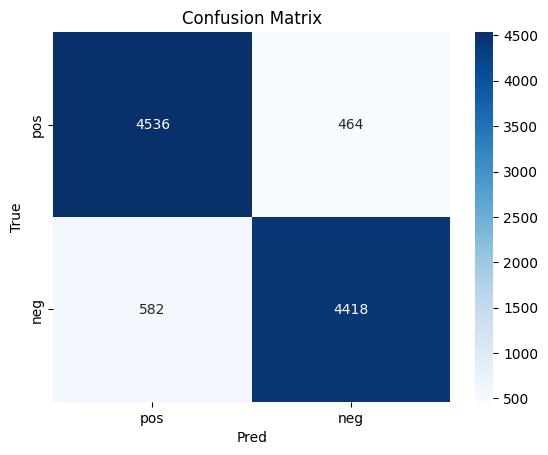

In [ ]:
# ============================================================
# Confusion matrix
# ============================================================
cm = confusion_matrix(y_test, y_pred, labels=['positive','negative'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.ylabel('True'); plt.xlabel('Pred'); plt.title("Confusion Matrix")
plt.show()

AUC-ROC: 0.96054348


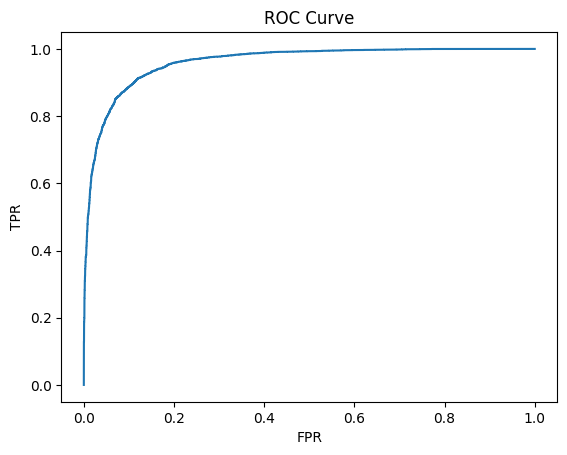

In [37]:
# ============================================================
# ROC curve check model's overall capability
# ============================================================
from sklearn.metrics import roc_curve
fpr, tpr, thr = roc_curve((y_test=='positive').astype(int), y_prob)
auc_score = roc_auc_score((y_test == 'positive').astype(int), y_prob)
plt.plot(fpr, tpr) 
plt.xlabel("FPR") 
plt.ylabel("TPR") 
plt.title("ROC Curve")
print("AUC-ROC:", auc_score)

In [38]:
# ============================================================
# Peek the misclassified reviews
# ============================================================
mis_idx = np.where(y_test != y_pred)[0]
for i in mis_idx[:5]:
    print("True:", y_test.iloc[i], "Pred:", y_pred[i])
    print(X_test.iloc[i], "\n---\n")

True: negative Pred: positive
story bride fair amusing engaging one filmmaker credit set portray rural minnesotan respect ordinarily reserved coastdwellers weird though find independent movie brainchild single person unambitious clichéridden committeebrewed hollywood potboilerthe portrait rural people intended affectionate think character dont ring true mei quite meal smalltown diner never overheard debate merit different nineteenthcentury english novelist one might suggest writerdirector semans experience rural culture coen brother considerably less satiric verve 
---

True: negative Pred: positive
little quentin seems mastered art cake eating itas usual pure sadistic display explained clever thoughtprovoking way sending violence back audience facesure mr tarantino violence baaad sadism baaad well worth wading make point brilliantthe juvenile part audience may well clever enough follow smart reference higher level consciousness though im confident theyll see light one daythanks making

In [40]:
# ============================================================
# Create a DataFrame for easier inspection
# ============================================================

results_df = pd.DataFrame({
    'review': X_test,
    'true_sentiment': y_test,
    'predicted_sentiment': y_pred
})


# ============================================================
# False Positives
# ============================================================
# The model predicted 'positive' but the actual sentiment was 'negative'.
false_positives = results_df[(results_df['true_sentiment'] == 'negative') & (results_df['predicted_sentiment'] == 'positive')]

print(f"Total False Positives: {len(false_positives)}")
print("="*30)
print("Displaying first 5 False Positives:")
for index, row in false_positives.head().iterrows():
    print("\n--- Review ---")
    print(row['review'])
    print(f"\nTrue: {row['true_sentiment']} | Predicted: {row['predicted_sentiment']}")
    print("-" * 15)



Total False Positives: 582
Displaying first 5 False Positives:

--- Review ---
story bride fair amusing engaging one filmmaker credit set portray rural minnesotan respect ordinarily reserved coastdwellers weird though find independent movie brainchild single person unambitious clichéridden committeebrewed hollywood potboilerthe portrait rural people intended affectionate think character dont ring true mei quite meal smalltown diner never overheard debate merit different nineteenthcentury english novelist one might suggest writerdirector semans experience rural culture coen brother considerably less satiric verve

True: negative | Predicted: positive
---------------

--- Review ---
little quentin seems mastered art cake eating itas usual pure sadistic display explained clever thoughtprovoking way sending violence back audience facesure mr tarantino violence baaad sadism baaad well worth wading make point brilliantthe juvenile part audience may well clever enough follow smart reference h

In [41]:
# ============================================================
# False Negatives
# ============================================================
# The model predicted 'negative' but the actual sentiment was 'positive'.
false_negatives = results_df[(results_df['true_sentiment'] == 'positive') & (results_df['predicted_sentiment'] == 'negative')]

print(f"\n\nTotal False Negatives: {len(false_negatives)}")
print("="*30)
print("Displaying first 5 False Negatives:")
for index, row in false_negatives.head().iterrows():
    print("\n--- Review ---")
    print(row['review'])
    print(f"\nTrue: {row['true_sentiment']} | Predicted: {row['predicted_sentiment']}")
    print("-" * 15)



Total False Negatives: 464
Displaying first 5 False Negatives:

--- Review ---
tenshu imprisoned sentenced death survives electrocution government official give choice either electrocute greater degree agree experiment chooses experimentation placed large metallic cell bad as criminal also survived electrocution whatever want room within reason cant leave day meal cut one per day room temp set 100 alarm sounded interval cant sleep one day witch come cell albeit glassed portion happens next ill let find may minority liked build intriguing payoff half good build would rated much highermy grade c medium blaster 2 dvd set extra disc 1 director cut trailer versus aragami attack gas station deadly outlaw rekka disc 2 theatrical cut commentary hideo sakaki ryuhei kitamura sakaguchi takuand tsutomu takahashi cast crew interview making original trailer promo teaser

True: positive | Predicted: negative
---------------

--- Review ---
cant believe comment show show genius sure doesnt follow tr

---

### Error Analysis

#### False Negatives

**Sample**

> cant believe comment show show genius sure doesnt follow tried true consumer always want thing thrust u shouldnt option sit back enjoy something new style realistic previous scooby doo show supposed show titled shaggy scooby doo get clue part title state entire beloved cast rendition would constantly join action nowhere say theyd solving mystery cant even stand monster would im actually glad put long standing plot point work scoobydoo show still running joke clumsy hijinks quickchange outfit chase scene standard hallway gag even scooby snack fact im glad show love im even glad got rid rest team concentrated two main character villainsure ridiculous supposed sure different supposed supposed make laugh villain cheer idiotic robotic butler triumph intruding vermin matter size youre supposed get running roobiroo joke whole thing put together well isnt single thing think wrong writing acting animation top notch title music awesome computer play get clue boot background music gripping

**🔵 Positive Words:**

* genius, new, realistic, glad (×2), love, top, notch, awesome, gripping

**🔴 Negative Words:**

* doesnt, idiotic,ridiculous, intruding, vermin, wrong

**📝 Observation**
The negative words is very strong, but it's not used to describe the movie, so this confused the model. Model can't understand context and distinguish which is describing the movie, and which is describing the other reviewers or character in the movie.


#### False Positive

**Sample**

> story bride fair amusing engaging one filmmaker credit set portray rural minnesotan respect ordinarily reserved coastdwellers weird though find independent movie brainchild single person unambitious clichéridden committeebrewed hollywood potboilerthe portrait rural people intended affectionate think character dont ring true mei quite meal smalltown diner never overheard debate merit different nineteenthcentury english novelist one might suggest writerdirector semans experience rural culture coen brother considerably less satiric verve.

**🔵 Positive Words:**

* amusing, engaging, credit, respect, affectionate

**🔴 Negative Words:**

* unambitious, clichéridden, weird

**📝 Observation**
Positive words is more than negative words, but overall tone of the review is clearly negative. This highlights that TF-IDF fails to capture the contextual relationship between or across words. If we want to address this problem, we need to use **modern transformer** to get the context.

---

#### Experiments

** Test Review 1:**  
> It had a good and educational topic, and I love the actor—but the confusing storyline made the movie really hard to understand. Overall, I'd give it a 3 out of 10.  
** Model prediction:** Positive(0.5517)   

This shows the TF-IDF don't know the vocab is describe movie or others, its across words feature extraction ability is week.

** Test Review 2:**  
> This movie shows what is beautifully wrapped box with nothing inside.   
** Model prediction:** Positive(0.6274)   

It shows that the model only looks at simple keywords and so mistakes a sarcastic negative comment for a positive one, unable to catch the context.


### **Conclusion**

In these experiments, TF-IDF with Logistic Regression often mistakes sarcasm or context for true sentiment because it only counts keywords. It cannot tell which words describe the movie and which describe reviewers or characters. As a result, it fails on negation, long-range context, and ambiguity. I will try using BERT next, since it can learn context and understand the meaning behind words.

---
### Summary of the work

#### **Approach**

**TF-IDF** (Feature Extraction) → **Logistic Regression** (Pattern Learning) → **Classifier** (Threshold = 0.5)

#### **Metrics Selection**

The dataset is well-balanced, and there is no specific business objective that requires prioritizing false positives or false negatives.
Therefore, the focus is on evaluating the model’s overall ability to distinguish between positive and negative reviews across a range of classification thresholds.

##### **Selected Evaluation Metrics**

* **Accuracy**: A straightforward measure of overall correctness.
* **F1-Score**: Balances precision and recall, especially useful for general model evaluation.
* **ROC AUC**: Assesses the model’s ability to separate classes across all possible thresholds.

##### **Performance**

* Accuracy: 89.54%  
* F1-Score: 89.66%  
* ROC AUC:  0.9605  

Not bad overall.


In [ ]:
# ============================================================
# Train the model on whole dataset for production
# ============================================================
X, y = df['clean_review'], df['sentiment']

tfidf = TfidfVectorizer(max_features=20_000)
X_tfidf = tfidf.fit_transform(X)

model = LogisticRegression(max_iter=1000)
model.fit(X_tfidf, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [44]:
# ============================================================
# Save the model
# ============================================================
import joblib
from datetime import datetime
joblib.dump(model, f'model/IMDB_tfidflr_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl')
joblib.dump(tfidf, f'model/IMDB_vectorizer_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl')

['model/IMDB_vectorizer_20250614_141139.pkl']

In [45]:
# Here is the baseline model, I consider use a more advanced architecture:
"""
1. text -> preprocess -> TF-IDF -> LR -> Label  
                                            
2. text -> preprocess -> DistillBert -> LR/MLP -> Label  

3. text -> GPT(structured output 4.1 nano) -> Label  (Human level accuracy, feedback)

Cons: latency, cost, data privacy
Pros: Accuracy

"""

'\n1. text -> preprocess -> TF-IDF -> LR -> Label  \n\n2. text -> preprocess -> DistillBert -> LR/MLP -> Label  \n\n3. text -> GPT(structured output 4.1 nano) -> Label  (Human level accuracy, feedback)\n\nCons: latency, cost, data privacy\nPros: Accuracy\n\n'